# Imports

In [9]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import mritopng
from PIL import Image

import torch

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.models.vgg import vgg19
import sys
sys.path.append('./Zero-Learning-Fast-Medical-Image-Fusion')
from utils import *

import shutil
import tensorflow as tf

current_path = os.getcwd()
data_path = os.path.join(current_path, 'Data\manifest-MjbMt99Q1553106146386120388')
metadata_path = os.path.join(data_path, 'metadata.csv')
info_path = os.path.join(data_path, 'INFOclinical_STS_csv.csv')
# import data
metadata = pd.read_csv(metadata_path)
info = pd.read_csv(info_path)

# EDA

In [10]:
info.head()

,Subject ID,MSKCC type,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days)
0,STS_001,Liposarcoma,left thigh,High,-7,4,Radiotherapy + Surgery + Chemotherapy,Mets - arms,266,D,845
1,STS_002,Leiomyosarcoma,left buttock,High,-10,25,Radiotherapy + Surgery,--,--,NED,501
2,STS_003,Other,right buttock,Intermediate,-13,15,Radiotherapy + Surgery,--,--,NED,756
3,STS_004,MFH,right thigh,Low,-6,22,Radiotherapy + Surgery,--,--,NED,1792
4,STS_005,Leiomyosarcoma,left biceps,High,-24,34,Radiotherapy + Surgery,--,--,NED,647


In [11]:
metadata.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT1,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.05 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:17.081
1,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T1 - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,21.06 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:18.905
2,1.3.6.1.4.1.14519.5.2.1.5168.1900.269249420684...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT2FS,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,793.95 KB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:20.531
3,1.3.6.1.4.1.14519.5.2.1.5168.1900.267475167888...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T2 FAT SAT - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,11.89 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:22.271
4,1.3.6.1.4.1.14519.5.2.1.5168.1900.147597676388...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PET CT,09-07-2000,RTstructAlignedT1toPET,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.22 MB,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,2022-12-04T15:17:22.541


In [12]:
metadata[['Number of Images','Modality']].groupby('Modality').sum()

,Number of Images
Modality,
CT,13607
MR,10753
PT,13617
RTSTRUCT,306


In [13]:
print(metadata[['Subject ID','Modality','Number of Images']]
      .groupby(['Subject ID', 'Modality'])
      .sum())

                     Number of Images
Subject ID Modality                  
STS_001    CT                     267
           MR                     201
           PT                     267
           RTSTRUCT                 6
STS_002    CT                     267
...                               ...
STS_050    RTSTRUCT                 6
STS_051    CT                     267
           MR                     198
           PT                     267
           RTSTRUCT                 6

[204 rows x 1 columns]


In [14]:
info[['Subject ID','MSKCC type']].groupby('MSKCC type').count()  

,Subject ID
MSKCC type,
Extraskeletal bone sarcoma,4
Fibrosarcoma,1
Leiomyosarcoma,10
Liposarcoma,11
MFH,17
Other,3
Synovial sarcoma,5


# Preprocessing

## Extract relevant image information

In [58]:
meta_extracted = metadata[['Subject ID','Modality','Number of Images', 'File Location','Series Description']]
info_extracted = info[['Subject ID','MSKCC type']]

In [59]:
# join two dataframes
meta_info_join = pd.merge(meta_extracted, info_extracted, on='Subject ID', how='left')

In [60]:
meta_info_join

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
0,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT1,Liposarcoma
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
2,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT2FS,Liposarcoma
3,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
4,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,RTstructAlignedT1toPET,Liposarcoma
...,...,...,...,...,...,...
607,STS_051,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,RTstructPET,Synovial sarcoma
608,STS_051,CT,267,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,CT IMAGES - LEGS - RESEARCH,Synovial sarcoma
609,STS_051,MR,50,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT1toPETBOX,Synovial sarcoma
610,STS_051,MR,52,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT2FStoPETBOX,Synovial sarcoma


## IMPORTANT

In [76]:
# check MR images
(meta_info_join[(meta_info_join['Modality'] == 'MR') & (meta_info_join['Series Description'].str.contains('PETBOX') != True)]
 [['Number of Images', 'MSKCC type']]
 .groupby(['MSKCC type']).sum())

,Number of Images
MSKCC type,
Extraskeletal bone sarcoma,284
Fibrosarcoma,100
Leiomyosarcoma,733
Liposarcoma,850
MFH,1176
Other,176
Synovial sarcoma,342


## drop irrelevant rows

In [18]:
# drop MSKCC type that are not Leiomyosarcoma, Liposarcoma, MFH
meta_info_join = meta_info_join[meta_info_join['MSKCC type'].isin(['Leiomyosarcoma', 'Liposarcoma', 'MFH'])]
meta_info_join = meta_info_join[meta_info_join['Modality'].isin(['MR'])]

In [19]:
meta_info_join

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
3,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
7,STS_001,MR,61,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,AlignedT1toPETBOX,Liposarcoma
10,STS_001,MR,60,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,AlignedT2FStoPETBOX,Liposarcoma
11,STS_002,MR,35,.\Soft-tissue-Sarcoma\STS_002\01-28-2006-NA-PE...,AllignedT1toPETBOX,Leiomyosarcoma
...,...,...,...,...,...,...
581,STS_049,MR,76,.\Soft-tissue-Sarcoma\STS_049\04-15-2002-NA-PE...,AlignedT1toPETBOX,Liposarcoma
590,STS_050,MR,62,.\Soft-tissue-Sarcoma\STS_050\01-27-2004-NA-PE...,AlignedSTIRtoPETBOX,Leiomyosarcoma
592,STS_050,MR,59,.\Soft-tissue-Sarcoma\STS_050\01-27-2004-NA-PE...,AlignedT1toPETBOX,Leiomyosarcoma
598,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma


In [20]:
#  png files location
file_location = meta_info_join['File Location'].tolist()
# add png infront of the file location
new_file_location = [x[:21] + '-png' + x[21:] for x in file_location]
meta_info_join['PNG File Location'] = new_file_location

In [21]:
meta_info_join[meta_info_join['Subject ID'] == 'STS_029']

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
335,STS_029,MR,30,.\Soft-tissue-Sarcoma\STS_029\10-08-2005-NA-MR...,Coronal Fast Stir,MFH,.\Soft-tissue-Sarcoma-png\STS_029\10-08-2005-N...
336,STS_029,MR,40,.\Soft-tissue-Sarcoma\STS_029\10-08-2005-NA-MR...,Axial T1 LT THIGH,MFH,.\Soft-tissue-Sarcoma-png\STS_029\10-08-2005-N...
344,STS_029,MR,81,.\Soft-tissue-Sarcoma\STS_029\11-04-2005-NA-PE...,AlignedSTIRtoPETBOX,MFH,.\Soft-tissue-Sarcoma-png\STS_029\11-04-2005-N...
345,STS_029,MR,83,.\Soft-tissue-Sarcoma\STS_029\11-04-2005-NA-PE...,AlignedT1toPETBOX,MFH,.\Soft-tissue-Sarcoma-png\STS_029\11-04-2005-N...


In [22]:
(meta_info_join[['Modality', 'MSKCC type', 'Number of Images']]
 .groupby(['Modality', 'MSKCC type'])
 .sum())

Number of Images
Modality MSKCC type                      
MR       Leiomyosarcoma              1981
         Liposarcoma                 2355
         MFH                         3862

In [23]:
#  Checkpoint 1:  meta_info_join
#  meta_info_join into csv
meta_info_join.to_csv('meta_info_join.csv', index=False)

## Convert dicom to png

In [24]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'Data//manifest-MjbMt99Q1553106146386120388')
metadata_path = os.path.join(data_path, 'metadata.csv')
info_path = os.path.join(data_path, 'INFOclinical_STS_csv.csv')
# import data
metadata = pd.read_csv(metadata_path)
info = pd.read_csv(info_path)

In [25]:
for i in range(len(meta_info_join)):
    try:
        mritopng.convert_folder(os.path.join(data_path, meta_info_join['File Location'].iloc[i])
                                , os.path.join(data_path, meta_info_join['PNG File Location'].iloc[i]))
    except:
        print(meta_info_join['File Location'].iloc[i], 'already converted')

.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\11.000000-AXIAL SE T1 - RESEARCH-12555 already converted
.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\10.000000-AXIAL SE T2 FAT SAT - RESEARCH-62438 already converted
.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PET CT-63929\5436027.000000-AlignedT1toPETBOX-88600 already converted
.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PET CT-63929\5442056.000000-AlignedT2FStoPETBOX-06608 already converted
.\Soft-tissue-Sarcoma\STS_002\01-28-2006-NA-PETCT with added MR-70477\6564013.000000-AllignedT1toPETBOX-15491 already converted
.\Soft-tissue-Sarcoma\STS_002\01-28-2006-NA-PETCT with added MR-70477\6570010.000000-AlignedSTIRtoPETBOX-57980 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\501.000000-AXT1-02298 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\701.000000-STIR longTE AX-10990 already converted
.\Soft-tissue-Sarcoma\STS_004\10-22-1999-NA-CT PET with registered MR-356

## Data Cleaning 

### Bit of manual cleaning --> remove images with only black background, extra images, etc.

### STS_029 having inconsistent data

In [26]:
#  drop sts_029
meta_info_join = meta_info_join[meta_info_join['Subject ID'] != 'STS_029']

In [27]:
meta_info_join.reset_index(drop=True, inplace=True)
meta_info_join

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
2,STS_001,MR,61,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,AlignedT1toPETBOX,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-07-2000-N...
3,STS_001,MR,60,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,AlignedT2FStoPETBOX,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-07-2000-N...
4,STS_002,MR,35,.\Soft-tissue-Sarcoma\STS_002\01-28-2006-NA-PE...,AllignedT1toPETBOX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-28-2006-N...
...,...,...,...,...,...,...,...
143,STS_049,MR,76,.\Soft-tissue-Sarcoma\STS_049\04-15-2002-NA-PE...,AlignedT1toPETBOX,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_049\04-15-2002-N...
144,STS_050,MR,62,.\Soft-tissue-Sarcoma\STS_050\01-27-2004-NA-PE...,AlignedSTIRtoPETBOX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-27-2004-N...
145,STS_050,MR,59,.\Soft-tissue-Sarcoma\STS_050\01-27-2004-NA-PE...,AlignedT1toPETBOX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-27-2004-N...
146,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...


### Update file name

In [28]:
#  change the word Soft-tissue-Sarcoma-png to Soft-tissue-Sarcoma-png - Manual Cleaning
meta_info_join['PNG File Location'] = meta_info_join['PNG File Location'].str.replace('Soft-tissue-Sarcoma-png', 'Soft-tissue-Sarcoma-png - Manual Cleaning')

### Update image number

In [29]:
# join png file location with data directory and update number of images based on png files
meta_info_join['Number of Images'] = (meta_info_join['PNG File Location']
                                      .apply(lambda x: os.path.join(data_path, x))
                                      .apply(lambda x: len(os.listdir(x))))

### Remove file location column

In [30]:
#  remove file location
meta_info_join = meta_info_join.drop('File Location', axis=1)

### Add a column that contain the parent directory

In [31]:
#  save original path
original_path = os.getcwd()

#  add a column that contain the parent directory
meta_info_join['Parent Directory'] = meta_info_join['PNG File Location'].apply(lambda x: os.path.join(data_path, x))
for i in range(len(meta_info_join)):
    #  move up one directory
    os.chdir(meta_info_join['Parent Directory'].iloc[i])
    os.chdir('..')
    #  record the child directory into the column
    parent_directory = os.getcwd()
    rel_parent_directory = os.path.relpath(parent_directory, start=data_path)
    meta_info_join['Parent Directory'].iloc[i] = ".\\" + rel_parent_directory

#  move back to original directory
os.chdir(original_path)

In [24]:
#  Checkpoint 2:  meta_info_join
#  meta_info_join into csv
meta_info_join.to_csv('meta_info_join.csv', index=False)

In [56]:
meta_info_join

,Subject ID,Modality,Number of Images,Series Description,MSKCC type,PNG File Location,Parent Directory,Fuse
0,STS_001,MR,40,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
1,STS_001,MR,40,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
2,STS_001,MR,60,AlignedT1toPETBOX,Liposarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
3,STS_001,MR,60,AlignedT2FStoPETBOX,Liposarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
4,STS_002,MR,31,AllignedT1toPETBOX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
...,...,...,...,...,...,...,...,...
143,STS_049,MR,67,AlignedT1toPETBOX,Liposarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
144,STS_050,MR,47,AlignedSTIRtoPETBOX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
145,STS_050,MR,47,AlignedT1toPETBOX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False
146,STS_050,MR,30,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,.\Soft-tissue-Sarcoma-png - Manual Cleaning\ST...,False


### Resizing images (takes time)

In [57]:
#  for each image in the png file location, resize to 224x224
for i in range(len(meta_info_join)):
    # png file location
    png_file_location = os.path.join(data_path, meta_info_join['PNG File Location'].iloc[i])
    image_list = os.listdir(png_file_location)
    for image in image_list:
        #  open image
        im = Image.open(os.path.join(png_file_location, image))
        #  resize image
        im = im.resize((224, 224))
        #  save image
        im.save(os.path.join(png_file_location, image))

## Fuse images (takes time)

In [54]:
# pretrained model
def fuse_images(image_1_path, image_2_path, output_path):
    def imread(image, mode):
        return np.array(Image.open(image).convert(mode))
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    r1, eps1, r2, eps2 = 45, 0.01, 7, 1e-6
    model = vgg19(pretrained=True)
    vgg19_relus = [1, 3, 8]

    # path_to_images = ['images/IV_images/1-38.dcm.png', 'images/IV_images/1-38.dcm - Copy.png']
    path_to_images = [image_1_path, image_2_path]

    imgs = [imread(p, mode='L') for p in path_to_images]

    float_imgs = [(img / 255.).astype(np.float32) for img in imgs]
    bases, details = decompose(float_imgs)

    Wb_0 = sal_weights(imgs)
    Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
    Wb = guided_optimize(float_imgs, Wb_0, r1, eps1)

    fused_base = weighted_sum(bases, Wb)

    tc_details = stack_to_tensor(details)
    fused_detial = cnn_detail_fusion(tc_details, model, device, relus=vgg19_relus)

    fused = np.clip(fused_base + fused_detial, 0, 1)
    fused = np.rint(fused * 255).astype(np.uint8)
    
    # save image in output path
    im = Image.fromarray(fused)
    im.save(output_path)

In [6]:
# create fuse column and have everything as false
meta_info_join['Fuse'] = False
while False in meta_info_join['Fuse'].tolist():
    #  check for the first row that is not fused
    first_fuse_row = meta_info_join[meta_info_join['Fuse'] == False].iloc[0]
    #  check for the rows that has the same parent directory and different png file location
    try:
        second_fuse_row = meta_info_join[(meta_info_join['Parent Directory'] == first_fuse_row['Parent Directory'])
                                         & (meta_info_join['PNG File Location'] != first_fuse_row['PNG File Location'])].iloc[0]
        if second_fuse_row.empty:
            raise Exception('Fuse Rows not found')
    except Exception as e:
        print(str(e))
    
    # fusing operations -------------------------------------------------------------------
    # list of images in the first row
    first_row_images = os.listdir(os.path.join(data_path, first_fuse_row['PNG File Location'][2:]))
    # list of images in the second row
    second_row_images = os.listdir(os.path.join(data_path, second_fuse_row['PNG File Location'][2:]))
    # make directory for fused images
    os.makedirs(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused'), exist_ok=True)
    for image_index in range(len(first_row_images)):
        image_number = image_index + 1
        image_number = str(image_number).zfill(3)
        fuse_image_name = 'fused-' + image_number + '.png'
        #  fuse the images
        fuse_images(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index]),
                    os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index]),
                    os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name))
    # end of fusing operations ------------------------------------------------------------
    
    #  change fuse to true for every parent directory that has the same parent directory
    meta_info_join.loc[meta_info_join['Parent Directory'] == first_fuse_row['Parent Directory'], 'Fuse'] = True

#  remove fuse column
meta_info_join = meta_info_join.drop('Fuse', axis=1)

NameError: name 'meta_info_join' is not defined

In [32]:
#  create a new dataframe that contains the parent directory of the fused images
meta_info_fused = meta_info_join.drop_duplicates(subset=['Parent Directory'])

meta_info_fused.drop(['PNG File Location', 'Modality'], axis=1, inplace=True)
#  add fused after the parent direcotry
meta_info_fused['Parent Directory'] = meta_info_fused['Parent Directory'] + '\\fused'
# rename parent directory to fused image directory
meta_info_fused.rename(columns={'Parent Directory': 'Fused Image Directory'}, inplace=True)
# update image count based on the number of images in the fused image directory
try:
    for i in range(len(meta_info_fused)):
        meta_info_fused['Number of Images'].iloc[i] = len(os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:])))
except:
    print('Error in updating image count')

Error in updating image count


In [33]:
meta_info_fused.reset_index(drop=True, inplace=True)
#  change the word  Soft-tissue-Sarcoma-png - Manual Cleaning to Soft-tissue-Sarcoma-png - Fused
meta_info_fused['Fused Image Directory'] = meta_info_fused['Fused Image Directory'].str.replace('Soft-tissue-Sarcoma-png - Manual Cleaning', 'Soft-tissue-Sarcoma-png - Fused')

## EDA and Pre-Proccessing on fused images

In [ ]:
#  checkpoint 3 - image augmentation
#  import meta_info_fused
# meta_info_fused = pd.read_csv('meta_info_fused.csv')
# meta_info_fused.to_csv('meta_info_fused.csv', index=False)

### PETBOX removal

In [34]:
meta_info_fused[meta_info_fused['Series Description'].str.contains('PETBOX')].reset_index(drop=True)
meta_info_fused.drop(meta_info_fused[meta_info_fused['Series Description'].str.contains('PETBOX')].index, inplace=True)
meta_info_fused.reset_index(drop=True, inplace=True)

In [35]:
meta_info_fused

,Subject ID,Number of Images,Series Description,MSKCC type,Fused Image Directory
0,STS_001,40,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png - Fused\STS_001\09-0...
1,STS_002,15,AXT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png - Fused\STS_002\01-0...
2,STS_004,30,T2ST RT - RESEARCH,MFH,.\Soft-tissue-Sarcoma-png - Fused\STS_004\09-3...
3,STS_005,33,AXIALT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png - Fused\STS_005\05-2...
4,STS_007,50,Axial FSET2 Fatsat,MFH,.\Soft-tissue-Sarcoma-png - Fused\STS_007\05-2...
5,STS_008,20,T1 AX - RESEARCH,MFH,.\Soft-tissue-Sarcoma-png - Fused\STS_008\08-0...
6,STS_009,65,Axial T1 UPPER - RESEARCH,MFH,.\Soft-tissue-Sarcoma-png - Fused\STS_009\03-1...
7,STS_010,48,2. AXIAL T1 BOTH LEGS - RESEARCH,MFH,.\Soft-tissue-Sarcoma-png - Fused\STS_010\12-1...
8,STS_013,45,T2ST LT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png - Fused\STS_013\07-0...
9,STS_014,54,AXIAL FRFSE T2 Fatsat - RESEARCH,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png - Fused\STS_014\11-1...


In [123]:
#  drop MFH 
# meta_info_fused = meta_info_fused[meta_info_fused['MSKCC type'] != 'MFH']

In [36]:
#  count number of images in based on the MSKCC type
meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum()

,Number of Images
MSKCC type,
Leiomyosarcoma,359
Liposarcoma,421
MFH,547


In [37]:
#  transfer images from their respectve directories to the folder that corresponds to their MSKCC type
new_data_path = os.path.join(data_path, 'Soft-tissue-Sarcoma - Classes')
leiomyosarcoma_index = 1
MFH_index = 1
liposarcoma_index = 1

for i in range(len(meta_info_fused)):
    #  create the new directory for the image
    os.makedirs(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i]), exist_ok=True)
    #  get the list of images in the fused image directory
    image_list = os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:]))
    for image in image_list:
        #  transfer the image to the new directory
        shutil.copy(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:], image),
                    os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image))
        # rename the image
        if meta_info_fused['MSKCC type'].iloc[i] == 'Leiomyosarcoma':
            # zfill to 4 digits and add the index
            image_number = str(leiomyosarcoma_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Leiomyosarcoma-' + image_number + '.png'))
            leiomyosarcoma_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'MFH':
            # zfill to 4 digits and add the index
            image_number = str(MFH_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'MFH-' + image_number + '.png'))
            MFH_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'Liposarcoma':
            # zfill to 4 digits and add the index
            image_number = str(liposarcoma_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Liposarcoma-' + image_number + '.png'))
            liposarcoma_index += 1

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\User\\Desktop\\repo\\Soft-Tissue-Sarcomas-Classification\\Data//manifest-MjbMt99Q1553106146386120388\\Soft-tissue-Sarcoma - Classes\\Liposarcoma\\fused-001.png' -> 'c:\\Users\\User\\Desktop\\repo\\Soft-Tissue-Sarcomas-Classification\\Data//manifest-MjbMt99Q1553106146386120388\\Soft-tissue-Sarcoma - Classes\\Liposarcoma\\Liposarcoma-0001.png'

# Model Building

## Use GPU 

In [38]:
# Check for GPU availability
gpu_devices = tf.config.list_physical_devices("GPU")
if gpu_devices:
    for device in gpu_devices:
        print("GPU:", device)
else:
    print("No GPU available.")

# Verify GPU usage in TensorFlow
tf.config.list_physical_devices('GPU')

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Splitting data into train and test

In [39]:
#  import train test split
from sklearn.model_selection import train_test_split

#  import metrics
from sklearn.metrics import confusion_matrix

In [40]:
def microprecision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [41]:
# import images from the new data path and do train test split, with their directory as their label
new_data_path = os.path.join(data_path, 'Soft-tissue-Sarcoma - Classes')
#  get the list of images
image_list = []
label_list = []
for root, dirs, files in os.walk(new_data_path):
    for file in files:
        if file.endswith('.png'):
            image_list.append(os.path.join(root, file))
            label_list.append(root.split('\\')[-1])

#  create a dataframe that contains the image path and their label
image_df = pd.DataFrame({'Image Path': image_list, 'Label': label_list})

# scramble the data random state 42
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)

#  split the data into train and test
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['Label'])
 
#  split the train data into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['Label']) # 0.25 x 0.8 = 0.2

#  one hot encode the labels
train_df = pd.concat([train_df, pd.get_dummies(train_df['Label'])], axis=1)
val_df = pd.concat([val_df, pd.get_dummies(val_df['Label'])], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Label'])], axis=1)

In [42]:
#  create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.5, 1.5],
    fill_mode='nearest',
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

#  create the train, validation and test generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col=['Leiomyosarcoma', 'Liposarcoma', 'MFH'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Image Path',
    y_col=['Leiomyosarcoma', 'Liposarcoma', 'MFH'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',
    y_col=['Leiomyosarcoma', 'Liposarcoma', 'MFH'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)


Found 795 validated image filenames.
Found 265 validated image filenames.
Found 266 validated image filenames.


In [48]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [78]:

#  create the model vgg16
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
vgg16.trainable = False

#  create the model adding another layer for better performance
# model = tf.keras.models.Sequential([
#     vgg16,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])


model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
25/25 [==============================] - 8s 317ms/step - loss: 1.6370 - categorical_accuracy: 0.4050 - microprecision: 0.4297 - val_loss: 1.1502 - val_categorical_accuracy: 0.4981 - val_microprecision: 0.5459
Epoch 2/100
25/25 [==============================] - 8s 306ms/step - loss: 1.0012 - categorical_accuracy: 0.5270 - microprecision: 0.5860 - val_loss: 0.7802 - val_categorical_accuracy: 0.6642 - val_microprecision: 0.7755
Epoch 3/100
25/25 [==============================] - 8s 311ms/step - loss: 0.9285 - categorical_accuracy: 0.5736 - microprecision: 0.6204 - val_loss: 0.7536 - val_categorical_accuracy: 0.6642 - val_microprecision: 0.7409
Epoch 4/100
25/25 [==============================] - 8s 308ms/step - loss: 0.8522 - categorical_accuracy: 0.5849 - microprecision: 0.6521 - val_loss: 0.6854 - val_categorical_accuracy: 0.7208 - val_microprecision: 0.7569
Epoch 5/100
25/25 [==============================] - 8s 314ms/step - loss: 0.8283 - categorical_accuracy: 0.6151 - m

9/9 [==============================] - 1s 73ms/step
                precision    recall  f1-score   support

Leiomyosarcoma       0.82      0.92      0.87        72
   Liposarcoma       0.91      0.87      0.89        84
           MFH       0.90      0.86      0.88       110

      accuracy                           0.88       266
     macro avg       0.88      0.88      0.88       266
  weighted avg       0.88      0.88      0.88       266



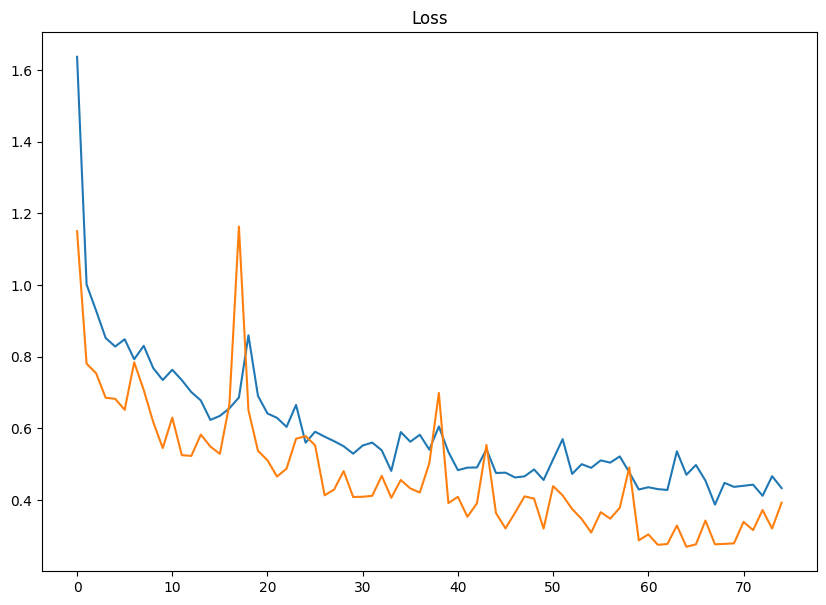

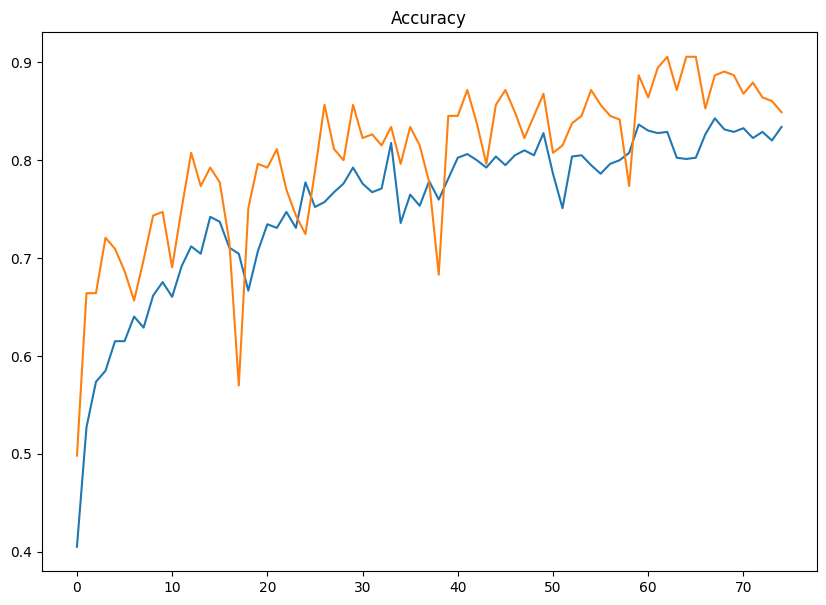

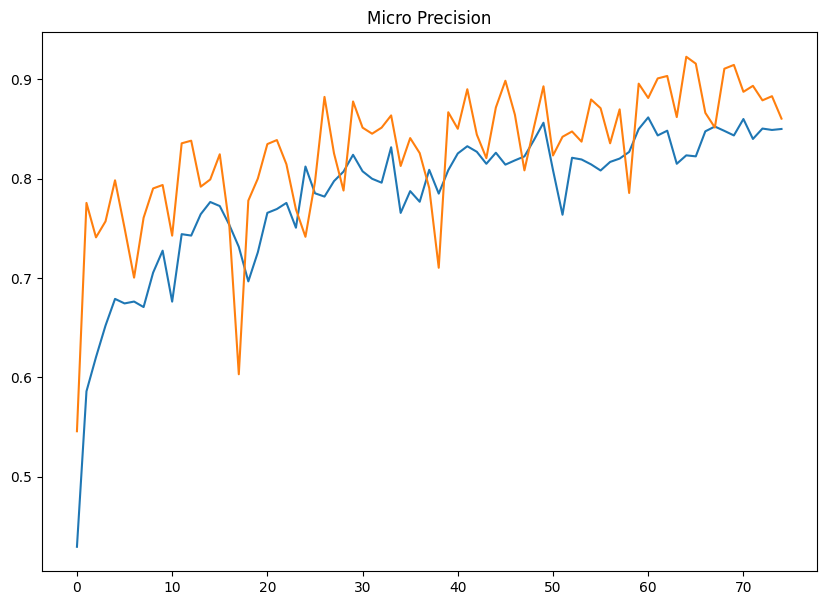

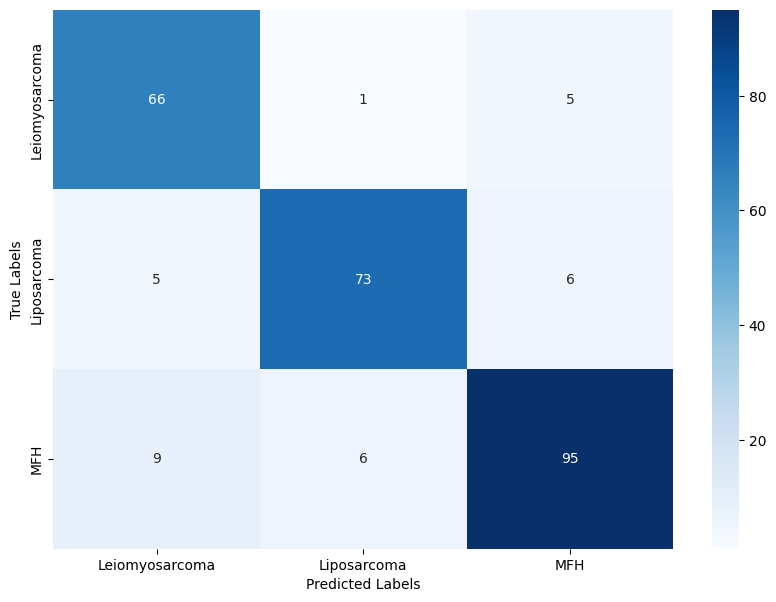

In [79]:
# import classification report
from sklearn.metrics import classification_report
# confusion matrix
from sklearn.metrics import confusion_matrix

#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.title('Micro Precision')

#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

# change the predicted labels to the original labels
predicted_labels = np.where(predicted_labels==0, 'Leiomyosarcoma', predicted_labels)
predicted_labels = np.where(predicted_labels=='1', 'Liposarcoma', predicted_labels)
predicted_labels = np.where(predicted_labels=='2', 'MFH', predicted_labels)

# change the true labels to the original labels
true_labels = np.where(true_labels==0, 'Leiomyosarcoma', true_labels)
true_labels = np.where(true_labels=='1', 'Liposarcoma', true_labels)
true_labels = np.where(true_labels=='2', 'MFH', true_labels)

#  get the classification report
print(classification_report(true_labels, predicted_labels))

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Leiomyosarcoma', 'Liposarcoma', 'MFH'], yticklabels=['Leiomyosarcoma', 'Liposarcoma', 'MFH'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


#  save the model
model.save('new_new_model.h5')

## Data Generator

In [77]:
# import image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [78]:
#  create image data generator for train and test
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=90, 
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

#  create train and test generator
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='Image Path', y_col='Label', target_size=(224, 224), batch_size=64, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(val_df, x_col='Image Path', y_col='Label', target_size=(224, 224), batch_size=64, class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='Image Path', y_col='Label', target_size=(224, 224), batch_size=64, class_mode='categorical')

Found 795 validated image filenames belonging to 3 classes.
Found 265 validated image filenames belonging to 3 classes.
Found 265 validated image filenames belonging to 3 classes.


## Model Building

### Model 1 - VGG16

In [136]:
#  import pretrained model
from tensorflow.keras.applications import VGG16

#  create the base model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

#  freeze the base model
base_model.trainable = False

#  create the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [137]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[microprecision, 'accuracy'])

# Create callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg_model3.h5', monitor='val_microprecision', save_best_only=True, save_weights_only=False, mode='max')

# Train the model
hist = model.fit(train_generator, epochs=30, callbacks=[checkpoint], validation_data=val_generator)

Epoch 1/30
19/19 [==============================] - 19s 958ms/step - loss: 0.7261 - microprecision: 0.5332 - accuracy: 0.5285 - val_loss: 0.6668 - val_microprecision: 0.5774 - val_accuracy: 0.5707
Epoch 2/30
19/19 [==============================] - 14s 716ms/step - loss: 0.6711 - microprecision: 0.5864 - accuracy: 0.5881 - val_loss: 0.6516 - val_microprecision: 0.5887 - val_accuracy: 0.5757
Epoch 3/30
19/19 [==============================] - 12s 611ms/step - loss: 0.6502 - microprecision: 0.6038 - accuracy: 0.6162 - val_loss: 0.6161 - val_microprecision: 0.6147 - val_accuracy: 0.6303
Epoch 4/30
19/19 [==============================] - 14s 729ms/step - loss: 0.6257 - microprecision: 0.6364 - accuracy: 0.6385 - val_loss: 0.6052 - val_microprecision: 0.6557 - val_accuracy: 0.6725
Epoch 5/30
19/19 [==============================] - 16s 811ms/step - loss: 0.6252 - microprecision: 0.6550 - accuracy: 0.6476 - val_loss: 0.5939 - val_microprecision: 0.6246 - val_accuracy: 0.6452
Epoch 6/30
19/1

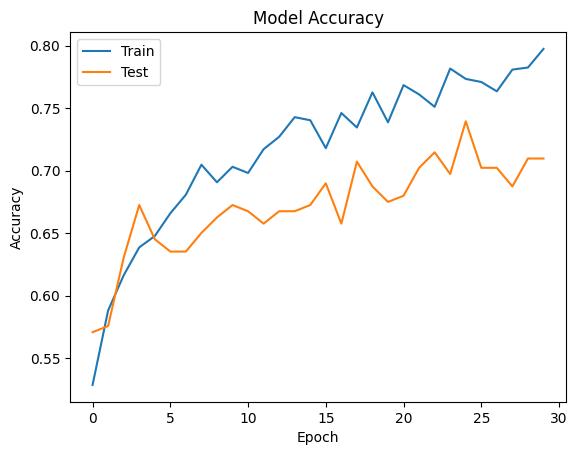

In [138]:
# plot hist
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [139]:
# # Wrap the custom metric function with custom_object_scope
# with tf.keras.utils.custom_object_scope({'microprecision': microprecision}):
#     model = tf.keras.models.load_model('vgg_model.h5')

# Evaluate the model
model.evaluate(test_generator)

7/7 [==============================] - 4s 617ms/step - loss: 0.4477 - microprecision: 0.7751 - accuracy: 0.7816


[0.44767260551452637, 0.7751253843307495, 0.7816377282142639]

In [140]:
#  confusion matrix
y_pred = model.predict(test_generator)
#  get the predicted labels
y_pred_ = np.argmax(y_pred, axis=1)


7/7 [==============================] - 3s 476ms/step


In [143]:
# y_pred to dataframe
y_pred_df = pd.DataFrame(y_pred, columns=['Leiomyosarcoma', 'Liposarcoma'])
y_pred_df['Predicted Label'] = y_pred_

y_pred_df['True Label'] = test_generator.labels

y_pred_df

,Leiomyosarcoma,Liposarcoma,Predicted Label,True Label
0,0.046530,0.955698,1,0
1,0.008663,0.991967,1,1
2,0.428545,0.599662,1,1
3,0.065415,0.938633,1,0
4,0.282015,0.711139,1,1
...,...,...,...,...
398,0.128941,0.877796,1,1
399,0.276747,0.735319,1,0
400,0.070576,0.937403,1,0
401,0.069098,0.935057,1,0


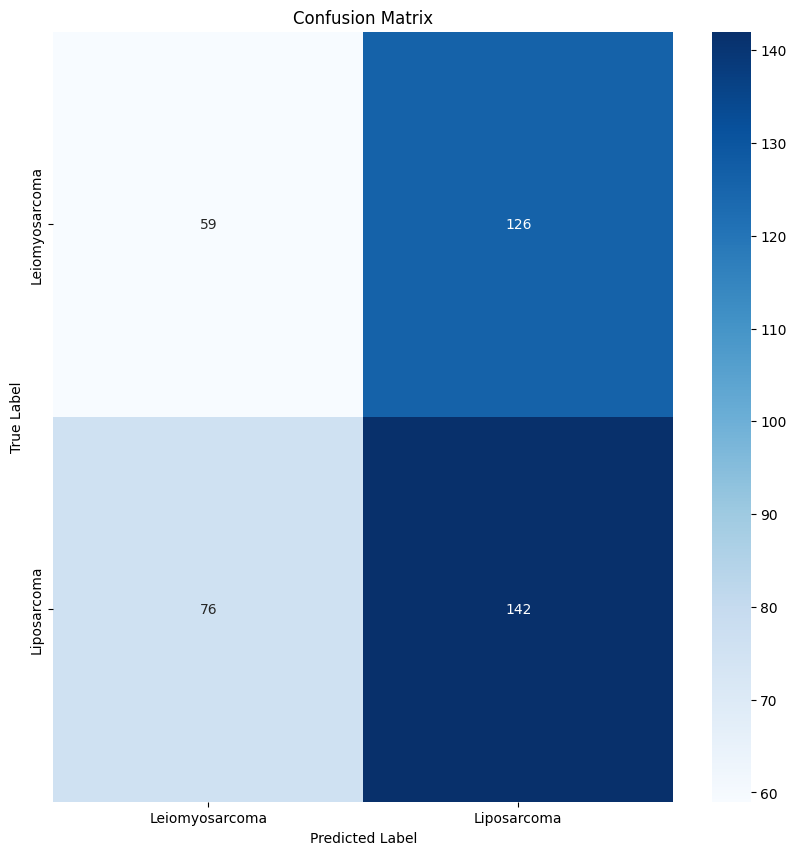

In [144]:
#  get the true labels
y_true = test_generator.classes

#  get the class names
class_names = list(test_generator.class_indices.keys())

#  create the confusion matrix
cm = confusion_matrix(y_true, y_pred_)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

#  plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [80]:
#  get the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_, target_names=class_names))

NameError: name 'y_true' is not defined

### Model 2 - resnet50

In [49]:
# restnet model
#  import pretrained model
from tensorflow.keras.applications import ResNet50

#  create the base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

#  freeze the base model
base_model.trainable = False

#  create the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

94765736/94765736 [==============================] - 8s 0us/step


In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=[microprecision, 'accuracy'])

# Create callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('restnet.h5', monitor='val_microprecision', save_best_only=True, save_weights_only=False, mode='max')

# Train the model
hist = model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[checkpoint])

Epoch 1/30
92/92 [==============================] - 31s 311ms/step - loss: 2.0014 - microprecision: 0.4252 - accuracy: 0.3998 - val_loss: 1.2437 - val_microprecision: 0.4388 - val_accuracy: 0.4169
Epoch 2/30
92/92 [==============================] - 27s 291ms/step - loss: 1.2750 - microprecision: 0.4561 - accuracy: 0.4390 - val_loss: 1.3922 - val_microprecision: 0.4731 - val_accuracy: 0.4673
Epoch 3/30
92/92 [==============================] - 26s 286ms/step - loss: 1.1999 - microprecision: 0.4709 - accuracy: 0.4482 - val_loss: 1.9997 - val_microprecision: 0.3161 - val_accuracy: 0.3065
Epoch 4/30
92/92 [==============================] - 27s 290ms/step - loss: 1.4094 - microprecision: 0.4468 - accuracy: 0.4342 - val_loss: 1.4914 - val_microprecision: 0.3442 - val_accuracy: 0.3324
Epoch 5/30
92/92 [==============================] - 27s 294ms/step - loss: 1.3749 - microprecision: 0.4637 - accuracy: 0.4461 - val_loss: 0.9837 - val_microprecision: 0.5824 - val_accuracy: 0.5218
Epoch 6/30
92/9

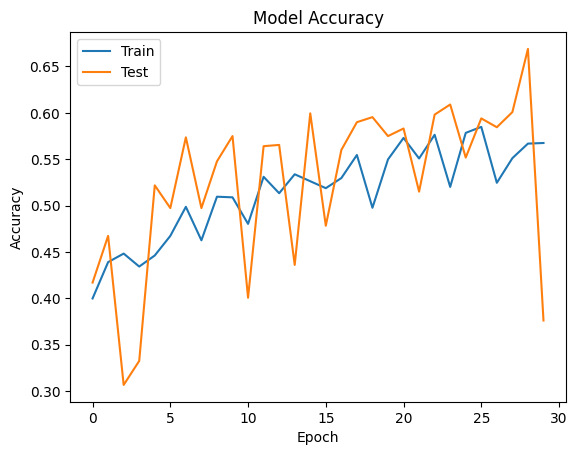

In [51]:
# plot hist
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

23/23 [==============================] - 120s 5s/step


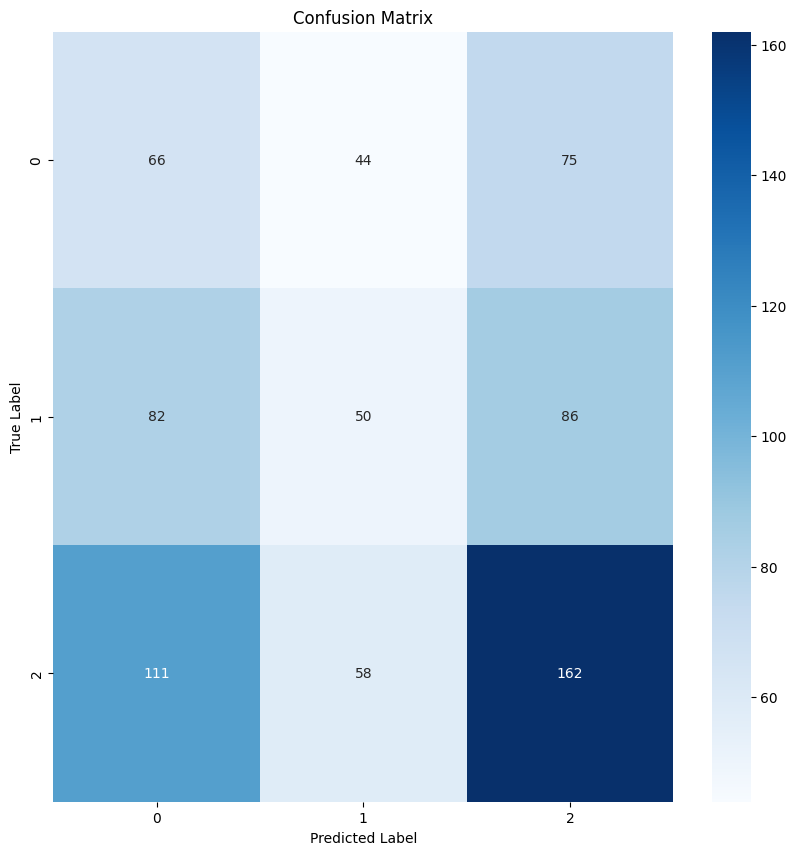

                precision    recall  f1-score   support

Leiomyosarcoma       0.25      0.36      0.30       185
   Liposarcoma       0.33      0.23      0.27       218
           MFH       0.50      0.49      0.50       331

      accuracy                           0.38       734
     macro avg       0.36      0.36      0.35       734
  weighted avg       0.39      0.38      0.38       734



In [53]:
# # Wrap the custom metric function with custom_object_scope
with tf.keras.utils.custom_object_scope({'microprecision': microprecision}):
    model = tf.keras.models.load_model('restnet.h5')

# Evaluate the model
model.evaluate(test_generator)

#  confusion matrix
y_pred = model.predict(test_generator)
#  get the predicted labels
y_pred_ = np.argmax(y_pred, axis=1)

#  get the true labels
y_true = test_generator.classes

#  get the class names
class_names = list(test_generator.class_indices.keys())

#  create the confusion matrix
cm = confusion_matrix(y_true, y_pred_)

#  plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#  get the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_, target_names=class_names))